In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [23]:
# file_list=['BTC-all','BTCUSDT-1h','ETH-all','ETHUSDT-1h']
df = pd.read_csv('../Data/ETHUSDT-1h.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
0,2022-08-01 08:00:00,1678.12,1690.58,1672.63,1688.31,29663.5047,1659315599999,4.984190e+07,34796,15165.9519,2.548902e+07,0
1,2022-08-01 09:00:00,1688.32,1699.08,1683.76,1696.74,19071.9861,1659319199999,3.226737e+07,26320,9837.4463,1.664619e+07,0
2,2022-08-01 10:00:00,1696.74,1704.68,1690.32,1695.04,17712.3643,1659322799999,3.004433e+07,24071,8758.1831,1.485804e+07,0
3,2022-08-01 11:00:00,1695.04,1696.79,1682.36,1691.77,13733.9485,1659326399999,2.319629e+07,21185,6754.5177,1.140844e+07,0
4,2022-08-01 12:00:00,1691.78,1697.00,1688.46,1695.00,10086.5889,1659329999999,1.707573e+07,16907,5157.6120,8.730825e+06,0


In [24]:
ad_fuller_result = adfuller(df['Close'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.8657947984978005
p-value: 0.3483193731741442


In [25]:
eps_diff = np.diff(df['Close'], n=1)

ad_fuller_result = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -15.887066072736182
p-value: 8.625666191344487e-29


In [26]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [27]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

In [28]:
int(len(df['Close'])*0.7)

6652

In [29]:
train = df['Close'][:int(len(df['Close'])*0.7)]

result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(2, 2)",50453.927066
1,"(3, 3)",50455.084012
2,"(3, 0)",50455.683504
3,"(0, 3)",50455.956652
4,"(3, 1)",50457.123895
5,"(2, 3)",50457.257491
6,"(1, 3)",50457.379717
7,"(2, 1)",50457.801701
8,"(1, 2)",50458.141003
9,"(3, 2)",50458.589576


In [15]:
model = SARIMAX(train, order=(2,1,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2290
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -16279.969
Date:                Mon, 02 Oct 2023   AIC                          32571.938
Time:                        09:17:45   BIC                          32606.354
Sample:                             0   HQIC                         32584.489
                               - 2290                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6200      0.026    -61.668      0.000      -1.671      -1.568
ar.L2         -0.8999      0.024    -37.323      0.000      -0.947      -0.853
ma.L1          1.6601      0.027     61.922      0.0

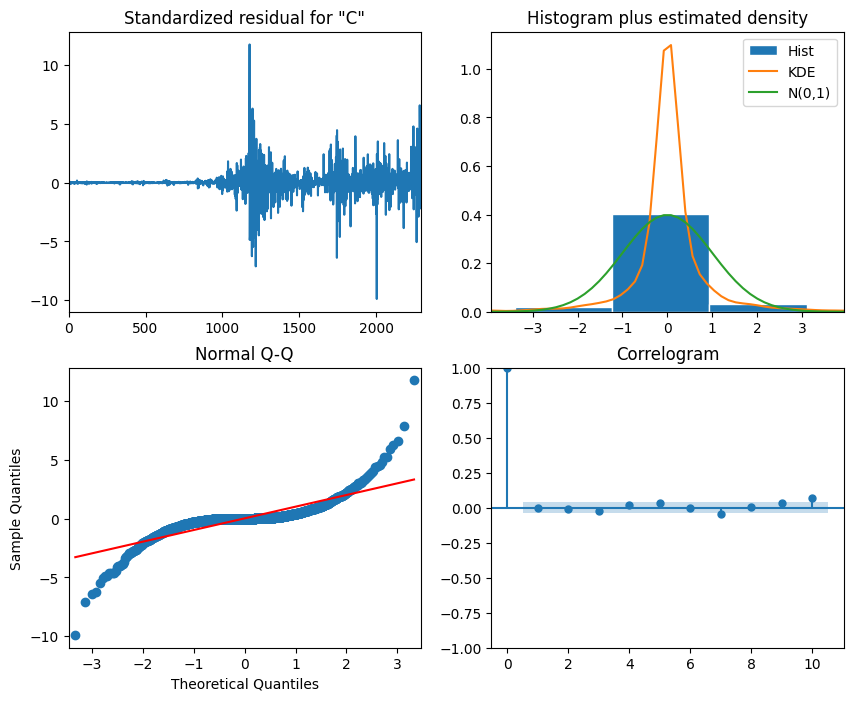

In [17]:
model_fit.plot_diagnostics(figsize=(10,8));

# plt.savefig('figures/CH07_F07_peixeiro.png', dpi=300)